In [9]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood,OnOffSVGPMC, OnOffSVGPPoiMC 
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

In [11]:
Ytrain[(Xtrain<=2)] = 1.0
Ytrain[(Xtrain>2) & (Xtrain<3)] = 0.0
Ytrain[(Xtrain>3) & (Xtrain<3.5)] = 3.0
Ytrain[(Xtrain>3.5) & (Xtrain<4)] = 4.0
Ytrain[(Xtrain>=4)] = 5.0

Ytrain[(Xtrain>7) & (Xtrain<9)] = 0.0

Xtrain = Xtrain.astype(gpf.default_float())
Ytrain = Ytrain.astype(gpf.default_float())
y_poi = tfp.distributions.Poisson(rate=Ytrain,force_probs_to_zero_outside_support=True)
Ytrain=y_poi.sample().numpy()

In [12]:
Ytrain

array([[ 3.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 3.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 3.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 5.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 2.],
       [ 3.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
      

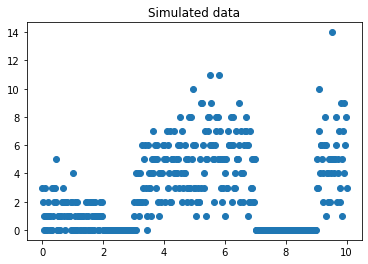

In [13]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [21]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [22]:
# model definition
m = OnOffSVGPPoiMC(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg, samples=100
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, False)

In [23]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [45]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
#logf = run_adam(m, 10)

In [46]:
%%time
logf = run_adam(m, 10000)

CPU times: user 1min 18s, sys: 27.1 s, total: 1min 45s
Wall time: 22.9 s


In [47]:
logf[-1]

-688.7367

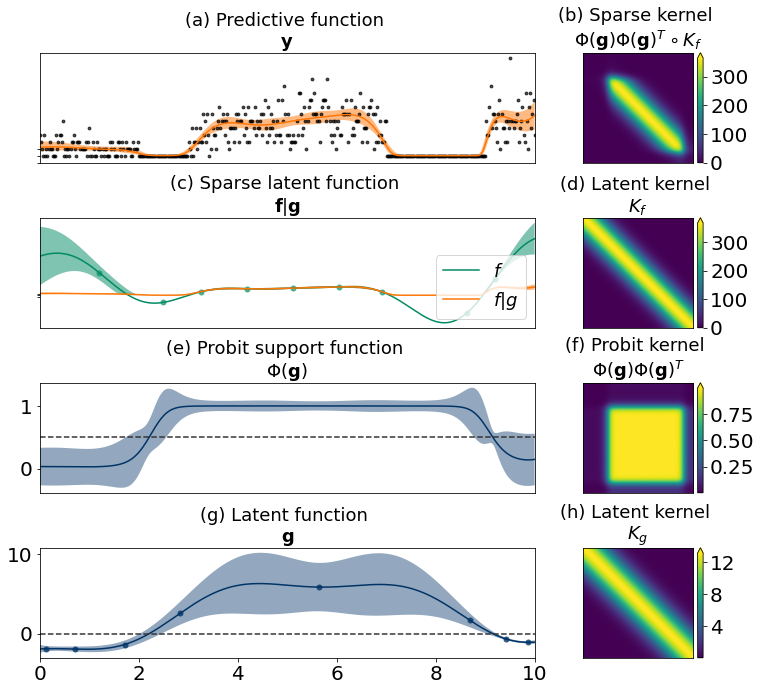

In [48]:
PlotOnOff1D(m, softplus=True)

In [ ]:
# get prior KL
KL = m.build_prior_KL()

# get augmented functions
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(m.X)

data_shape = m.X.shape
u = tf.random.normal(shape=data_shape + (m.samples,))
w = tf.random.normal(shape=data_shape + (m.samples,))

# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u * g_std_NDS

In [ ]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

phi_g_samples = normcdf(g_samples)

In [ ]:
f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

In [ ]:
f_samples

In [ ]:
tf.reduce_max(tf.math.softplus(f_samples))

In [ ]:
tf.reduce_max(f_samples)

In [ ]:
m.trainable_variables

In [ ]:
Zg